# 🎞️ IMDB Movie Reviews Sentiment Analysis

### 📔 Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import spacy

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


### 🔢 Dataset

In [8]:
!pip install -U datasets huggingface_hub fsspec # install this fix the bug "ValueError: Invalid pattern: ‘**’ can only be an entire path component"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
from datasets import load_dataset
from google.colab import userdata
from huggingface_hub import login
import os

# 1. Retrieve your Hugging Face API token from Colab's Userdata secrets
# Make sure you have a secret named 'huggingface' in Colab secrets
# (Tools -> Secrets -> + New secret -> Name: huggingface, Value: your_hf_token)
hf_token = userdata.get('huggingface')

# 2. Log in to Hugging Face Hub using the retrieved token
# This is necessary if the dataset is private or for certain operations
if hf_token:
    login(token=hf_token)
    print("Successfully logged in to Hugging Face Hub!")
else:
    print("Hugging Face token not found in Colab secrets. Proceeding without login (may fail for private datasets).")

# 3. Load the dataset
# If the dataset is public, this might work even without explicit login if no token is needed.
# If it's private or requires a token for access, the login step above is crucial.
try:
    ds = load_dataset("ajaykarthick/imdb-movie-reviews")
    print("\nDataset loaded successfully!")
    print(ds) # Print the dataset structure to confirm
    print(ds['train'][0]) # Print the first example from the training split
except Exception as e:
    print(f"\nError loading dataset: {e}")
    print("Please ensure the dataset exists, is public, or your Hugging Face token is correct and has access.")

# You can now work with the 'ds' object, which is a DatasetDict
# For example, to access the training split:
# train_dataset = ds['train']
# print(train_dataset[0])

Successfully logged in to Hugging Face Hub!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]


Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})
{'review': "Ms Aparna Sen, the maker of Mr & Mrs Iyer, directs this movie about a young girl's struggle to cope with her debilitating condition.<br /><br />Meethi (Konkona Sen) has been an aloof kid ever since childhood and has shown signs of delusion, no one knows why. The dormant tendency however slips out of control, when the job assignment takes her to neighboring Bihar where she's raped by some political goons. The resulting trauma also leads to episodes of manic-depressive psychosis in addition to her schizophrenia. She careens out of control over the years, progressively getting worse and sinking deeper into her private 'world'.<br /><br />The juxtaposition of an 'unsettled' (divorced) elder sister and how her domineering ways make an already bad situatio

In [3]:
# turn ds into dataframe to make it ez to work with
train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()

In [4]:
# visualize the table
train_df.head()

,review,label
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0
1,"I have seen this film only once, on TV, and it...",0
2,I was only fourteen when I first saw the Alien...,1
3,This marvelous short will hit home with everyo...,0
4,If you are 10 years old and never seen a movie...,1


**Note that 0 is negative and 1 is positive**

### 🩺 EDA

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [7]:
# take a look at a sample
train_df.sample(1)

,review,label
15997,Del - 'You are the dumbest smart person I've e...,1


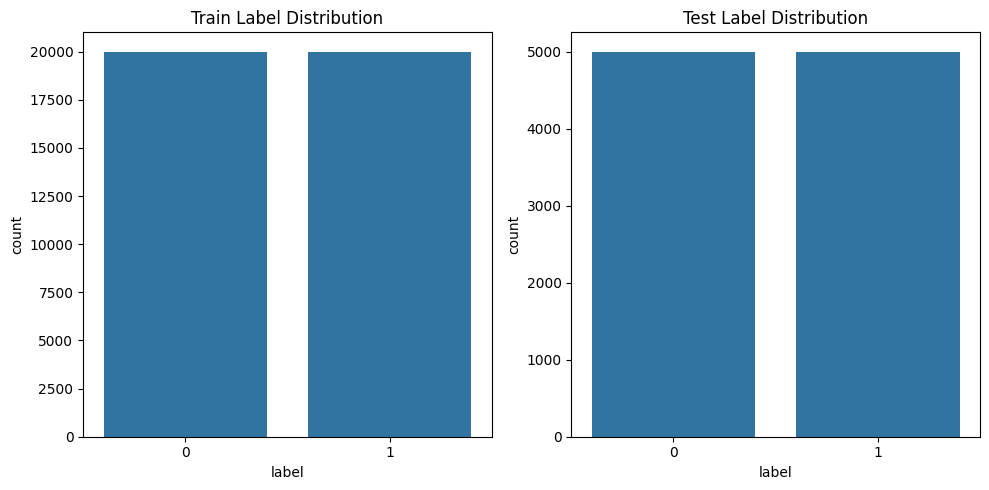

In [8]:
# check for class balance
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=train_df, x='label', ax=ax[0])
ax[0].set_title("Train Label Distribution")

sns.countplot(data=test_df, x='label', ax=ax[1])
ax[1].set_title("Test Label Distribution")

plt.tight_layout()
plt.show()

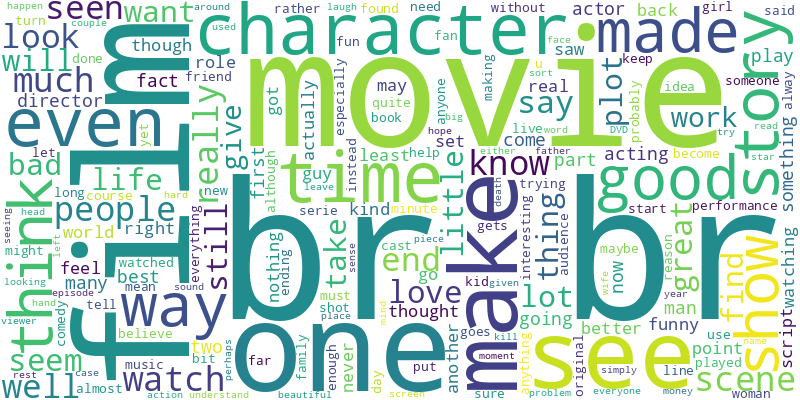

In [ ]:
# using wordcloud to visualize
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color='white')
wc.generate(" ".join(train_df['review'])).to_image()

### ♻️ Preprocessing & Text Normalization

In [10]:
# load pretrained english NLP pipeline
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

In [41]:
# get a text sample
text = train_df['review'][0]
text

"Ms Aparna Sen, the maker of Mr & Mrs Iyer, directs this movie about a young girl's struggle to cope with her debilitating condition.<br /><br />Meethi (Konkona Sen) has been an aloof kid ever since childhood and has shown signs of delusion, no one knows why. The dormant tendency however slips out of control, when the job assignment takes her to neighboring Bihar where she's raped by some political goons. The resulting trauma also leads to episodes of manic-depressive psychosis in addition to her schizophrenia. She careens out of control over the years, progressively getting worse and sinking deeper into her private 'world'.<br /><br />The juxtaposition of an 'unsettled' (divorced) elder sister and how her domineering ways make an already bad situation worse, is indicative of what a fine line there is between abnormal and *seemingly normal*. Ms Sen also makes an excellent commentary on the social alienation of such individuals. Social rehab is standard therapy along with all the deadly

In [42]:
# --- Lowercasing (Manual) ---
# although spaCy tokens have a .lower_ attribute, we can start by lowercasing the raw text
# this is often done before tokenization if we want truly case-insensitive processing
text_lowercased = text.lower()
print(f"Lowercased: {text_lowercased}")

Lowercased: ms aparna sen, the maker of mr & mrs iyer, directs this movie about a young girl's struggle to cope with her debilitating condition.<br /><br />meethi (konkona sen) has been an aloof kid ever since childhood and has shown signs of delusion, no one knows why. the dormant tendency however slips out of control, when the job assignment takes her to neighboring bihar where she's raped by some political goons. the resulting trauma also leads to episodes of manic-depressive psychosis in addition to her schizophrenia. she careens out of control over the years, progressively getting worse and sinking deeper into her private 'world'.<br /><br />the juxtaposition of an 'unsettled' (divorced) elder sister and how her domineering ways make an already bad situation worse, is indicative of what a fine line there is between abnormal and *seemingly normal*. ms sen also makes an excellent commentary on the social alienation of such individuals. social rehab is standard therapy along with all

In [43]:
# --- Tokenization (SpaCy handles this automatically when creating a Doc object) ---
# create a doc object
doc = nlp(text_lowercased)
# get the individual tokens
tokens = [token.text for token in doc]
print(f"Tokens: {tokens}")

Tokens: ['ms', 'aparna', 'sen', ',', 'the', 'maker', 'of', 'mr', '&', 'mrs', 'iyer', ',', 'directs', 'this', 'movie', 'about', 'a', 'young', 'girl', "'s", 'struggle', 'to', 'cope', 'with', 'her', 'debilitating', 'condition.<br', '/><br', '/>meethi', '(', 'konkona', 'sen', ')', 'has', 'been', 'an', 'aloof', 'kid', 'ever', 'since', 'childhood', 'and', 'has', 'shown', 'signs', 'of', 'delusion', ',', 'no', 'one', 'knows', 'why', '.', 'the', 'dormant', 'tendency', 'however', 'slips', 'out', 'of', 'control', ',', 'when', 'the', 'job', 'assignment', 'takes', 'her', 'to', 'neighboring', 'bihar', 'where', 'she', "'s", 'raped', 'by', 'some', 'political', 'goons', '.', 'the', 'resulting', 'trauma', 'also', 'leads', 'to', 'episodes', 'of', 'manic', '-', 'depressive', 'psychosis', 'in', 'addition', 'to', 'her', 'schizophrenia', '.', 'she', 'careens', 'out', 'of', 'control', 'over', 'the', 'years', ',', 'progressively', 'getting', 'worse', 'and', 'sinking', 'deeper', 'into', 'her', 'private', "'", "

In [ ]:
# --- Removing Punctuation and Numbers (Using token attributes) ---
# we create a list of cleaned tokens, focusing on alphabetic tokens

cleaned_tokens = [token for token in tokens if token.isalpha()]
print(f"Cleaned Tokens: {cleaned_tokens}")

Cleaned Tokens: ['ms', 'aparna', 'sen', 'the', 'maker', 'of', 'mr', 'mrs', 'iyer', 'directs', 'this', 'movie', 'about', 'a', 'young', 'girl', 'struggle', 'to', 'cope', 'with', 'her', 'debilitating', 'konkona', 'sen', 'has', 'been', 'an', 'aloof', 'kid', 'ever', 'since', 'childhood', 'and', 'has', 'shown', 'signs', 'of', 'delusion', 'no', 'one', 'knows', 'why', 'the', 'dormant', 'tendency', 'however', 'slips', 'out', 'of', 'control', 'when', 'the', 'job', 'assignment', 'takes', 'her', 'to', 'neighboring', 'bihar', 'where', 'she', 'raped', 'by', 'some', 'political', 'goons', 'the', 'resulting', 'trauma', 'also', 'leads', 'to', 'episodes', 'of', 'manic', 'depressive', 'psychosis', 'in', 'addition', 'to', 'her', 'schizophrenia', 'she', 'careens', 'out', 'of', 'control', 'over', 'the', 'years', 'progressively', 'getting', 'worse', 'and', 'sinking', 'deeper', 'into', 'her', 'private', 'juxtaposition', 'of', 'an', 'unsettled', 'divorced', 'elder', 'sister', 'and', 'how', 'her', 'domineering',

In [ ]:
# --- Removing Stop Words (Using token attributes) ---
# We filter the cleaned_tokens further

# check the token to see if it's in the spacy's list of stopwords
tokens_without_stopwords = [token for token in cleaned_tokens if not nlp.vocab[token].is_stop]
print(f"Tokens Without Stopwords: {tokens_without_stopwords}")

Tokens Without Stopwords: ['ms', 'aparna', 'sen', 'maker', 'mr', 'mrs', 'iyer', 'directs', 'movie', 'young', 'girl', 'struggle', 'cope', 'debilitating', 'konkona', 'sen', 'aloof', 'kid', 'childhood', 'shown', 'signs', 'delusion', 'knows', 'dormant', 'tendency', 'slips', 'control', 'job', 'assignment', 'takes', 'neighboring', 'bihar', 'raped', 'political', 'goons', 'resulting', 'trauma', 'leads', 'episodes', 'manic', 'depressive', 'psychosis', 'addition', 'schizophrenia', 'careens', 'control', 'years', 'progressively', 'getting', 'worse', 'sinking', 'deeper', 'private', 'juxtaposition', 'unsettled', 'divorced', 'elder', 'sister', 'domineering', 'ways', 'bad', 'situation', 'worse', 'indicative', 'fine', 'line', 'abnormal', 'seemingly', 'normal', 'ms', 'sen', 'makes', 'excellent', 'commentary', 'social', 'alienation', 'individuals', 'social', 'rehab', 'standard', 'therapy', 'deadly', 'mind', 'altering', 'drugs', 'poor', 'destitute', 'left', 'fend', 'usually', 'fall', 'romantic', 'connecti

In [ ]:
# --- Lemmatization (Using token attributes, typically after POS tagging) ---
# we have to re-process the original text to get full spaCy pipeline benefits including POS for lemmatization
# since we have manually lowercased the text which can affect lemmatization

doc_full = nlp(text)

lemmatized_tokens = []
for token in doc_full:
  # spacy treates pronouns specially, lematizing them to '-PRON'
  lemma = token.lemma_
  if lemma == '-PRON':
    # if the lemma of the word is PRON then keep the word I -> I, they -> they
    lemmatized_tokens.append(token.text.lower())
  elif not token.is_punct and not token.is_digit and not token.is_space:
    lemmatized_tokens.append(lemma.lower())

# lemmatization with stop words and punctuation for context
print(f"Lemmatized Tokens: {lemmatized_tokens}")
#

Lemmatized Tokens: ['ms', 'aparna', 'sen', 'the', 'maker', 'of', 'mr', 'mrs', 'iyer', 'direct', 'this', 'movie', 'about', 'a', 'young', 'girl', "'s", 'struggle', 'to', 'cope', 'with', 'her', 'debilitate', 'condition.<br', '/><br', '/>meethi', 'konkona', 'sen', 'have', 'be', 'an', 'aloof', 'kid', 'ever', 'since', 'childhood', 'and', 'have', 'show', 'sign', 'of', 'delusion', 'no', 'one', 'know', 'why', 'the', 'dormant', 'tendency', 'however', 'slip', 'out', 'of', 'control', 'when', 'the', 'job', 'assignment', 'take', 'she', 'to', 'neighbor', 'bihar', 'where', 'she', 'be', 'rape', 'by', 'some', 'political', 'goon', 'the', 'result', 'trauma', 'also', 'lead', 'to', 'episode', 'of', 'manic', 'depressive', 'psychosis', 'in', 'addition', 'to', 'her', 'schizophrenia', 'she', 'careen', 'out', 'of', 'control', 'over', 'the', 'year', 'progressively', 'get', 'bad', 'and', 'sink', 'deeply', 'into', 'her', 'private', "world'.<br", '/><br', '/>the', 'juxtaposition', 'of', 'an', 'unsettled', 'divorced'

In [2]:
# COMBINE ALL THE STEPS

def preprocess_text(text):
  # create doc object
  doc = nlp(text)
  processed_tokens = []
  for token in doc:
    # lowercase, lemmatize, remove stopwords, punctuation, and spaces
    if not token.is_stop and not token.is_punct and not token.is_digit and not token.is_space:
      lemma = token.lemma_
      if lemma == '-PRON':
        processed_tokens.append(token.text.lower())
      else:
        processed_tokens.append(lemma.lower())
  return " ".join(processed_tokens)

In [ ]:
# combined processing steps
print("------Processed Text------")
processed_sentence = preprocess_text(text)
print(f"Original: {text}")
print(f"Processed: {processed_sentence}")

------Processed Text------
Original: Ms Aparna Sen, the maker of Mr & Mrs Iyer, directs this movie about a young girl's struggle to cope with her debilitating condition.<br /><br />Meethi (Konkona Sen) has been an aloof kid ever since childhood and has shown signs of delusion, no one knows why. The dormant tendency however slips out of control, when the job assignment takes her to neighboring Bihar where she's raped by some political goons. The resulting trauma also leads to episodes of manic-depressive psychosis in addition to her schizophrenia. She careens out of control over the years, progressively getting worse and sinking deeper into her private 'world'.<br /><br />The juxtaposition of an 'unsettled' (divorced) elder sister and how her domineering ways make an already bad situation worse, is indicative of what a fine line there is between abnormal and *seemingly normal*. Ms Sen also makes an excellent commentary on the social alienation of such individuals. Social rehab is standa

In [3]:
import re
# as we can see, there are still noises like html tags, urls, and emails
# ae create a funciton to remove those noises

def remove_noise(text):
  # remove html tags
  text_no_html = re.sub(r'<[^>]+>', '', text)
  # Remove URLs
  text_no_urls = re.sub(r'http\S+|www.\S+', '', text_no_html)
  # Remove emails
  text_no_emails = re.sub(r'\S*@\S*\s?', '', text_no_urls)

  return text_no_emails

In [ ]:
processed_sentence_no_noise = remove_noise(processed_sentence)
print(f"Original: {processed_sentence}")
print(f"Processed: {processed_sentence_no_noise}")

Original: ms aparna sen maker mr mrs iyer direct movie young girl struggle cope debilitate condition.<br /><br />meethi konkona sen aloof kid childhood show sign delusion know dormant tendency slip control job assignment take neighbor bihar rape political goon result trauma lead episode manic depressive psychosis addition schizophrenia careen control year progressively get bad sink deeply private world'.<br /><br />the juxtaposition unsettled divorced eld sister domineering way bad situation bad indicative fine line abnormal seemingly normal ms sen make excellent commentary social alienation individual social rehab standard therapy deadly mind alter drug poor destitute leave fend usually fall wayside?<br /><br />the romantic connection dr kunal anu unnecessary cafeteria scene dr kunal explain anu real world redundant anu know english dialog bit awkward time act compensate konkona shabana prove reputation bit worth waheeda rahul shefali play limit role < br /><br />extensive research il

In [4]:
# final preprocessing function
# COMBINE ALL THE STEPS
# we optimize the function and use nlp.pipe to utilize batching
def batch_preprocess(texts):
    '''
    When we pass texts to nlp.pipe(), it expects texts to be something it can iterate over,
    where each item in the iteration is a document (a string) to be processed
    We need to conver the input into a list so nlp.pipe() can iterate over it
    If not, say we input a sentence (without converting to a list), it will iterate over every character
    '''
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=32)):
        tokens = [
            token.lemma_.lower() if token.lemma_ != "-PRON" else token.text.lower()
            for token in doc
            if not (token.is_stop or token.is_punct or token.is_digit or token.is_space)
        ]
        processed_texts.append(remove_noise(" ".join(tokens)))
    return processed_texts

In [ ]:
print("Preprocessing training set...")
# converting to a plain Python list since nlp.pipe expects an iterable of strings
train_df['review'] = batch_preprocess(train_df['review'].tolist())

print("Preprocessing test set...")
test_df['review'] = batch_preprocess(test_df['review'].tolist())

Preprocessing training set...


40000it [09:53, 67.41it/s]


Preprocessing test set...


10000it [02:21, 70.92it/s]


In [ ]:
# visualize the change
train_df.head()

,review,label
0,ms aparna sen maker mr mrs iyer direct movie y...,0
1,see film tv repeat strange consider rubbish re...,0
2,fourteen see alien movie immediately come like...,1
3,marvelous short hit home child specifically as...,0
4,year old see movie maybe film entertainment se...,1


In [ ]:
# Save the preprocessed data to csv file and store on gg drive since the preprocessing time is long
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # save to CSV
# train_df.to_csv('/content/drive/MyDrive/imdb_train_preprocessed.csv', index=False)
# test_df.to_csv('/content/drive/MyDrive/imdb_test_preprocessed.csv', index=False)

### 🤖 Model

**Bag-of-words**

In [60]:
# count vectorizer for bag of words
cv = CountVectorizer(max_features=10000, binary=False,ngram_range=(1,3))

In [61]:
X_train_bow = cv.fit_transform(train_df['review'])
X_test_bow = cv.transform(test_df['review'])

In [62]:
print("BOW training shape: ", X_train_bow.shape)
print("BOW test shape: ", X_test_bow.shape)

BOW training shape:  (40000, 10000)
BOW test shape:  (10000, 10000)


In [53]:
# tf-idf vectorization, turning words into numbers
vectorizer = TfidfVectorizer(max_features=10000, use_idf=True, ngram_range=(1,3))

In [54]:
# vectoriza training and test set
X_train_tfidf = vectorizer.fit_transform(train_df['review'])
X_test_tfidf = vectorizer.transform(test_df['review'])

In [55]:
print("TF-IDF training shape: ", X_train_tfidf.shape)
print("TF-IDF test shape: ", X_test_tfidf.shape)

TF-IDF training shape:  (40000, 10000)
TF-IDF test shape:  (10000, 10000)


In [9]:
# get the label
y_train = train_df['label']
y_test = test_df['label']

**Logistic Regression**

In [64]:
# training the model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42, verbose=1)

In [65]:
# Fit the model for bow
lr_bow = lr.fit(X_train_bow, y_train)
lr_bow

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s finished


LogisticRegression(C=1, max_iter=500, random_state=42, verbose=1)

In [66]:
lr_tfidf = lr.fit(X_train_tfidf, y_train)
lr_tfidf

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


LogisticRegression(C=1, max_iter=500, random_state=42, verbose=1)

### Prediction

In [ ]:
# Predict on test set
lr_bow_pred = lr_bow.predict(X_test_bow)
lr_tfidf_pred = lr_tfidf.predict(X_test_tfidf)

In [ ]:
# Accuracy of the model
lr_bow_score = accuracy_score(y_test, lr_bow_pred)
lr_tfidf_score = accuracy_score(y_test, lr_tfidf_pred)

print("Accuracy score of Logistic Regression using BOW: ", lr_bow_score)
print("Accuracy score of Logistic Regression using TF-IDF: ", lr_tfidf_score)

Accuracy score of Logistic Regression using BOW:  0.8685
Accuracy score of Logistic Regression using TF-IDF:  0.8876


In [ ]:
# classification report
lr_bow_report = classification_report(y_test, lr_bow_pred, target_names=['Positive', 'Negative'])
print(lr_bow_report)

              precision    recall  f1-score   support

    Positive       0.85      0.90      0.87      5000
    Negative       0.89      0.84      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
lr_tfidf_report = classification_report(y_test, lr_tfidf_pred, target_names=['Positive', 'Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.87      0.91      0.89      5000
    Negative       0.90      0.87      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



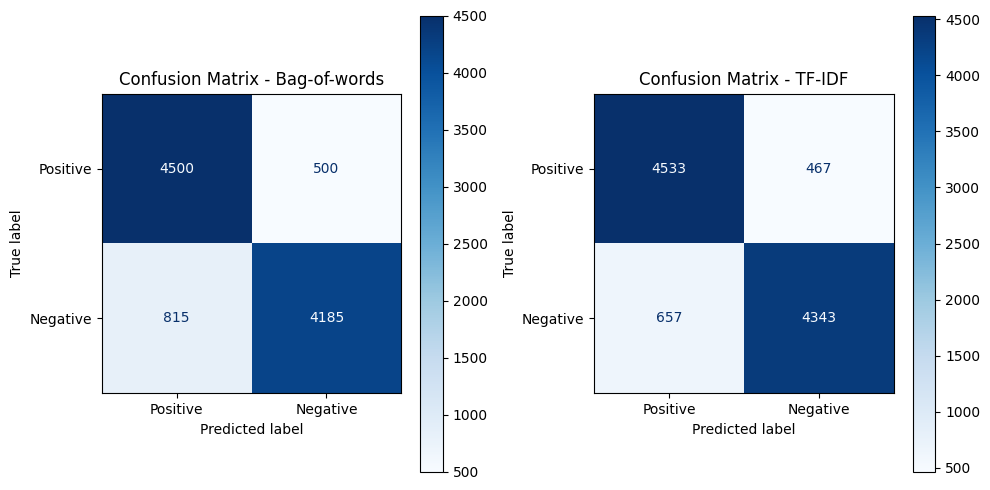

In [ ]:
# plot confusion matrix

cm_bow = confusion_matrix(y_test, lr_bow_pred, labels=[0,1])
cm_tfidf = confusion_matrix(y_test, lr_tfidf_pred, labels=[0,1])
# display
cm_bow_disp = ConfusionMatrixDisplay(confusion_matrix=cm_bow, display_labels=['Positive', 'Negative'])
cm_tfidf_disp = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['Positive', 'Negative'])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cm_bow_disp.plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title("Confusion Matrix - Bag-of-words")
cm_tfidf_disp.plot(ax=ax[1], cmap=plt.cm.Blues)
ax[1].set_title("Confusion Matrix - TF-IDF")

plt.tight_layout()
plt.show()

### 🍿Sample Movie review prediction

In [7]:
import joblib
lr_tfidf = joblib.load('imdb_sentiment_model.pkl')
vectorizer = joblib.load('imdb_vectorizer.pkl')

In [8]:
# function to analyze sentiment
def analyze_sentiment(review):
    # preprocess the input
    text = batch_preprocess([review]) # batch_preprocess takes in a list
    # vectorize using tf-idf
    vector = vectorizer.transform(text)
    # get analysis
    analysis = lr_tfidf.predict(vector)
    # map output to sentiment, 0 is positive, 1 is negative
    sentiment = "Positive" if analysis[0] == 0 else "Negative"
    # return sentiment of the output (analysis will be either 0 or 1)
    return sentiment

In [12]:
# get input from the user
user_input = input("Enter your movie review: ")
print("📽️ Your movie review:", user_input)
print("🍿 Your attitude towards this movie is: ", analyze_sentiment(user_input))

Enter your movie review: I hate the director. He sucks at his job. 
📽️ Your movie review: I hate the director. He sucks at his job. 


1it [00:00, 160.40it/s]

🍿 Your attitude towards this movie is:  Negative


In [ ]:
print("Sentiment: ", analyze_sentiment('This movie is a masterpiece!'))
print("Sentiment: ", analyze_sentiment('This movie is terrible!'))

1it [00:00, 112.46it/s]


Sentiment:  Positive


1it [00:00, 258.70it/s]

Sentiment:  Negative


### Save the model



In [ ]:
import joblib

joblib.dump(lr_tfidf, 'imdb_sentiment_model.pkl')
joblib.dump(vectorizer, 'imdb_vectorizer.pkl')

['imdb_vectorizer.pkl']

## 👾 Try with DistilBERT Pretrained Model

In [11]:
# load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Get an example

In [12]:
example = test_df['review'][0]
example_label = test_df['label'][0]
print(f'Example: {example}')
print(f'Label: {example_label}')

Example: Essentially plotless action film has two good guys (Fong and Roundtree) pitted against two bad guys (Mitchell and Pierce). Fong is perhaps the most uncharismatic action lead of the 80s, Roundtree's small part is a far cry from his 'Shaft' days, and Cameron Mitchell adds another shameful role to his career, one to sit right next to his laughable turn in 'The Toolbox Murders' (this man was a respected actor once, now he has come down to wearing flowers in his hair and complaining about people bleeding on his carpet). Only Stack Pierce acts with some dignity. As for the violence, don't worry: most of it is too badly done to offend anyone. (*1/2)
Label: 1


In [13]:
# run for DistilBert Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'DistilBert_neg' : scores[0],
    'DistilBert_pos' : scores[1]
}
print(scores_dict)

{'DistilBert_neg': np.float32(0.9917359), 'DistilBert_pos': np.float32(0.00826411)}


In [14]:
def distilbert_analyze_sentiment(text):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  return np.argmax(scores)

### Run and compare with Logistic Regression

In [15]:
test_df = test_df.reset_index()
test_df = test_df.rename(columns={'index': 'Id'})
test_df.head()

,Id,review,label
0,0,Essentially plotless action film has two good ...,1
1,1,I grew up on this movie and I can remember whe...,0
2,2,This was the best movie I've ever seen about B...,0
3,3,This film is about a bunch of misfits who are ...,0
4,4,"Bad plot, bad acting, bad direction.<br /><br ...",1


In [23]:
import torch
### BATCH INFERENCE ###
# convert to list to feed to the model
texts = test_df['review'].tolist()

# define batch size
batch_size = 32
distilbert_pred = []

# process in batches
for i in tqdm(range(0, len(texts), batch_size)):
  # get the batch
  batch_texts = texts[i:i+batch_size]

  # tokenize the batch
  tokenized_texts = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)

  # move to GPU if available
  if torch.cuda.is_available():
    # [('input_ids', tensor), ('attention_mask', tensor)]: returned values of tokenized_texts
    # k is key and v is vector which we send to the gpu because our model will be in gpu
    tokenized_texts = {k: v.to('cuda') for k, v in tokenized_texts.items()}
    model.to('cuda')

  # get predictions
  with torch.no_grad():
    outputs = model(**tokenized_texts)
    # flip the output
    # distilbert ouputs 0 for negative and 1 for positive, but our dataset is the inverse
    batch_preds = 1 - torch.argmax(outputs.logits, dim=1).cpu().numpy()
    distilbert_pred.extend(batch_preds)


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


In [24]:
# classification report
lr_bert_report = classification_report(y_test, distilbert_pred, target_names=['Positive', 'Negative'])
print(lr_bert_report)

              precision    recall  f1-score   support

    Positive       0.91      0.85      0.88      5000
    Negative       0.86      0.92      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



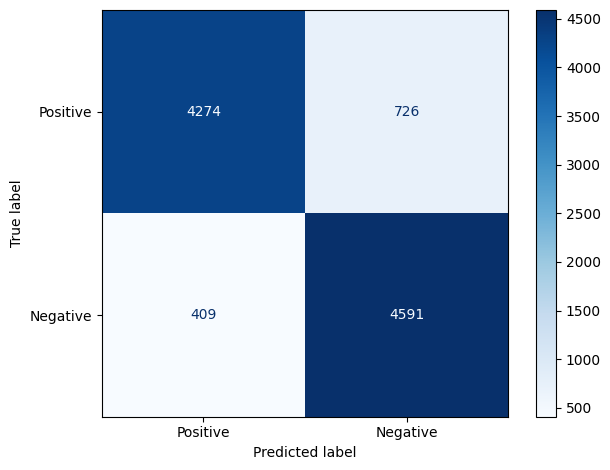

In [25]:
# plot confusion matrix
cm_bert= confusion_matrix(y_test, distilbert_pred, labels=[0,1])
# display
cm_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=['Positive', 'Negative'])

cm_bert.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()